In [ ]:
!pip install -q git+https://github.com/quantumjot/cellx.git

In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as K 

from skimage.io import imread, imsave

In [ ]:
from cellx.networks import UNet
from cellx.layers import ResidualBlock2D

In [ ]:
INPUT_SHAPE = (128, 128, 1)
OUTPUT_SHAPE = (128, 128, 2)
BATCH_SIZE = 4
TRAINING_EPOCHS = 20 
STEPS_PER_EPOCH = 16

In [ ]:
unet = UNet(
    convolution=ResidualBlock2D,
    layers=[8, 16, 32, 64],
    skip='concatenate',
    output_filters=OUTPUT_SHAPE[-1],
)

In [ ]:
x = K.layers.Input(shape=INPUT_SHAPE)
net = unet(x)
y = K.layers.Softmax(axis=-1)(net)

In [ ]:
model = K.Model(inputs=x, outputs=y)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
unet (UNet)                  (None, 128, 128, 2)       130508    
_________________________________________________________________
softmax (Softmax)            (None, 128, 128, 2)       0         
Total params: 130,508
Trainable params: 129,440
Non-trainable params: 1,068
_________________________________________________________________


In [ ]:
def generator(batch_size: int = BATCH_SIZE):

    xx, yy = np.meshgrid(
        np.arange(-INPUT_SHAPE[0]//2, INPUT_SHAPE[0]//2),
        np.arange(-INPUT_SHAPE[1]//2, INPUT_SHAPE[1]//2),
    )
    radius = np.sqrt(xx*xx + yy*yy)

    while True:
        images = []
        labels = []
        for i in range(batch_size):
            r = np.random.randint(1, INPUT_SHAPE[0]//2)
            mask = radius < r 

            image = mask*np.random.random()*10 
            image = image + np.random.randn(*INPUT_SHAPE[:2])*3.

            label = np.stack([1-mask, mask], axis=-1)

            images.append(image[..., np.newaxis])
            labels.append(label)

        images = np.stack(images, axis=0)
        labels = np.stack(labels, axis=0)
        yield images, labels


In [ ]:
training_data = generator()

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
model.fit(
    training_data,
    batch_size=BATCH_SIZE,
    epochs=TRAINING_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)

Epoch 1/20
16/16 [==============================] - 12s 496ms/step - loss: 0.3600 - accuracy: 0.8748
Epoch 2/20
16/16 [==============================] - 8s 490ms/step - loss: 0.2695 - accuracy: 0.9278
Epoch 3/20
16/16 [==============================] - 8s 489ms/step - loss: 0.2043 - accuracy: 0.9611
Epoch 4/20
16/16 [==============================] - 8s 489ms/step - loss: 0.2207 - accuracy: 0.9467
Epoch 5/20
16/16 [==============================] - 8s 490ms/step - loss: 0.1780 - accuracy: 0.9496
Epoch 6/20
16/16 [==============================] - 8s 491ms/step - loss: 0.1676 - accuracy: 0.9493
Epoch 7/20
16/16 [==============================] - 8s 485ms/step - loss: 0.1225 - accuracy: 0.9829
Epoch 8/20
16/16 [==============================] - 8s 486ms/step - loss: 0.1786 - accuracy: 0.9577
Epoch 9/20
16/16 [==============================] - 8s 486ms/step - loss: 0.1408 - accuracy: 0.9579
Epoch 10/20
16/16 [==============================] - 8s 494ms/step - loss: 0.1545 - accuracy: 0.949

In [ ]:
testing_data = generator(batch_size=1)

In [ ]:
X, Y = next(testing_data)

In [ ]:
y = model.predict(X)

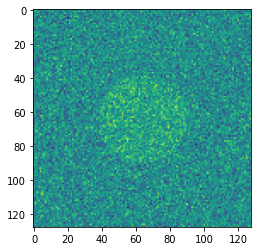

In [ ]:
# input image
plt.imshow(np.squeeze(X))

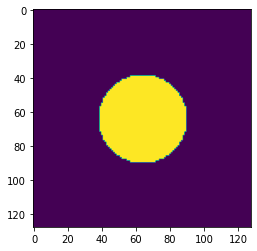

In [ ]:
# ground truth segmentation
plt.imshow(np.squeeze(np.argmax(Y, axis=-1)))

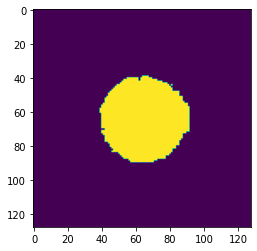

In [ ]:
# unet segmentation
plt.imshow(np.squeeze(np.argmax(y, axis=-1)))

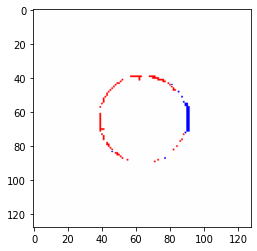

In [ ]:
# show the difference between the GT and the prediction
plt.imshow(
    np.squeeze(np.argmax(Y, axis=-1)) - np.squeeze(np.argmax(y, axis=-1)), 
    cmap='bwr',
)